In [1]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd
import spacy
import seaborn as sns

from functools import partial
from mpl_lego.labels import bold_text
from scipy.stats import bootstrap
from pyprojroot import here
from spacy_cleaner import processing, Cleaner
from textacy import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

from moral_foundations_llms import keys
 
%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
nlp = spacy.load("en_core_web_lg")

In [4]:
df = pd.read_csv(here('data/aita_final_v29.csv'))

In [5]:
# Preprocessing function
def preprocess(text):
    return preprocessing.make_pipeline(
        preprocessing.normalize.quotation_marks,
        preprocessing.normalize.whitespace,
        preprocessing.remove.brackets,
        preprocessing.remove.punctuation
    )(text)

In [6]:
# spaCy pipe applied to 
with nlp.disable_pipes('ner'):
    docs = {
        reason_col: list(nlp.pipe([preprocess(text)
                                   for text in df[reason_col]],
                                  batch_size=64))
        for reason_col in keys.REASON_COLS
    }

In [18]:
with nlp.disable_pipes('ner'):
    docs2 = {
        reason_col: list(nlp.pipe([preprocess(text)
                                   for text in df[reason_col]],
                                  batch_size=64))
        for reason_col in keys.REASON_COLS_2
    }

In [7]:
# Create tokenization
tokens = {model:
          [" ".join([token.lemma_ for token in current_doc 
                     if not token.is_stop
                     and not token.is_punct
                     and not token.like_num
                     and not token.is_currency
                     and not token in ['NTA', 'YTA', 'ESH', 'NAH', 'INF'] ])
           for current_doc in doc]
           for model, doc in docs.items()}

In [31]:
# Create tokenization
tokens2 = {model:
          [" ".join([token.lemma_ for token in current_doc 
                     if not token.is_stop
                     and not token.is_punct
                     and not token.like_num
                     and not token.is_currency
                     and not token in ['NTA', 'YTA', 'ESH', 'NAH', 'INF'] ])
           for current_doc in doc]
           for model, doc in docs2.items()}

In [8]:
tfidf_dfs = {}

for model, token in tokens.items():
    vectorizer = TfidfVectorizer(max_features=3000, max_df=0.98, min_df=5)
    X = vectorizer.fit_transform(token)
    tfidf_dfs[model] = pd.DataFrame(data=X.toarray(),
                                    columns=vectorizer.get_feature_names_out())

In [32]:
tfidf_dfs2 = {}

for model, token in tokens2.items():
    vectorizer = TfidfVectorizer(max_features=3000, max_df=0.98, min_df=5)
    X = vectorizer.fit_transform(token)
    tfidf_dfs2[model] = pd.DataFrame(data=X.toarray(),
                                     columns=vectorizer.get_feature_names_out())

In [9]:
token_sets = []

for tfidf_df in tfidf_dfs.values():
    token_sets.append(set(tfidf_df.columns))

matching_tokens = set.union(*token_sets)

In [1]:
len(matching_tokens)

NameError: name 'matching_tokens' is not defined

In [12]:
# Ensure all matrices have the same columns
standardized_tfidf_dfs = []

for tfidf_df in tfidf_dfs.values():
    # Reindex the DataFrame to include all matching tokens
    standardized_df = tfidf_df.reindex(columns=matching_tokens, fill_value=0)
    standardized_tfidf_dfs.append(standardized_df)

In [33]:
# Ensure all matrices have the same columns
standardized_tfidf_dfs2 = []

for tfidf_df in tfidf_dfs2.values():
    # Reindex the DataFrame to include all matching tokens
    standardized_df = tfidf_df.reindex(columns=matching_tokens, fill_value=0)
    standardized_tfidf_dfs2.append(standardized_df)

In [14]:
corrs = np.zeros((8, 8))

for ii in range(8):
    for jj in range(8):
        corrs[ii, jj] = np.diag(cosine_similarity(tfidf_dfs_matching[ii], tfidf_dfs_matching[jj])).mean()

NameError: name 'tfidf_dfs_matching' is not defined

In [15]:
corrs = np.zeros((8, 8))

for ii in range(8):
    for jj in range(8):
        corrs[ii, jj] = np.diag(cosine_similarity(standardized_tfidf_dfs[ii], standardized_tfidf_dfs[jj])).mean()

In [34]:
for ii in range(8):
    corrs[ii, ii] = np.diag(cosine_similarity(standardized_tfidf_dfs[ii], standardized_tfidf_dfs2[ii])).mean()

In [41]:
mask = np.zeros((len(keys.MODELS), len(keys.MODELS)))
mask[0, 0] = 1

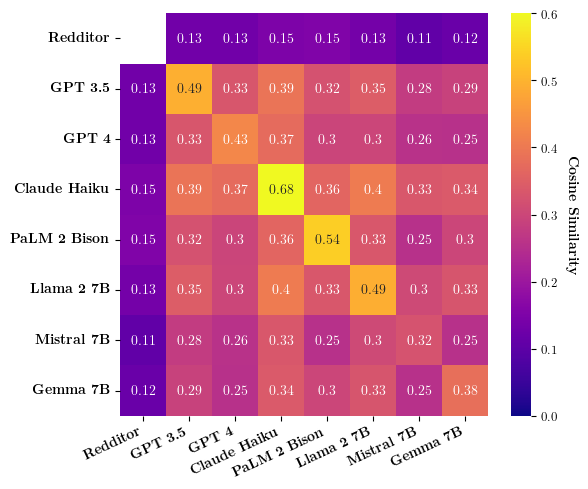

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sns.heatmap(corrs,
            annot=True,
            vmin=0.,
            vmax=0.6,
            mask=mask,
            cmap='plasma')
cbar = ax.collections[0].colorbar
cbar.set_label(bold_text("Cosine Similarity"), rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=9)

ax.set_xticklabels(bold_text(keys.MODEL_LABELS_PLOT), ha='right', rotation=25)
ax.set_yticklabels(bold_text(keys.MODEL_LABELS_PLOT), ha='right', rotation=0)
plt.tight_layout()
plt.savefig('word_similarity_tfidf.pdf', bbox_inches='tight')